# Preprocessing the audio files


## Feature Type 1：spectrogram:

In [1]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

train_audio_path = 'train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(os.path.join(train_audio_path , filename))

In [2]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0,0.5,'Freqs in Hz')

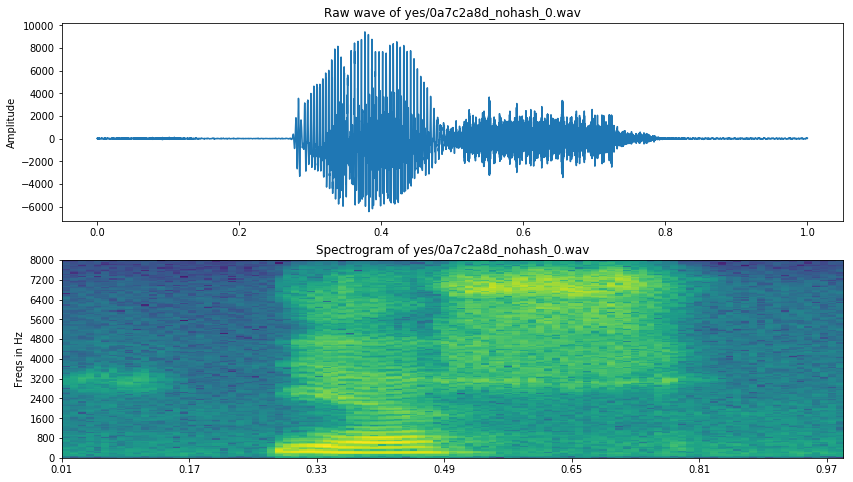

In [3]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
#ax2.set_xlabel('Seconds')

In [4]:
# normalize the features
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

## Feature Type2 ：MFCC


MFCC (Mel Frequency Cepstral Coefficients) -- a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.


http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

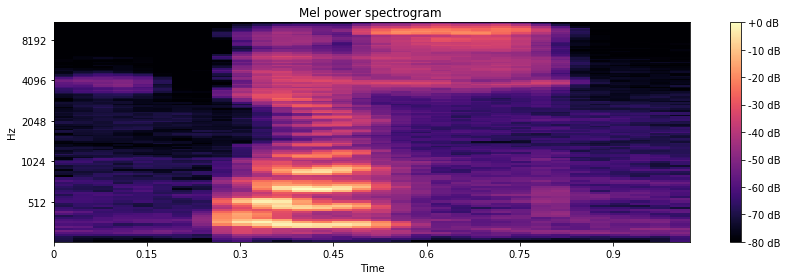

In [5]:
import librosa
import librosa.display

S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

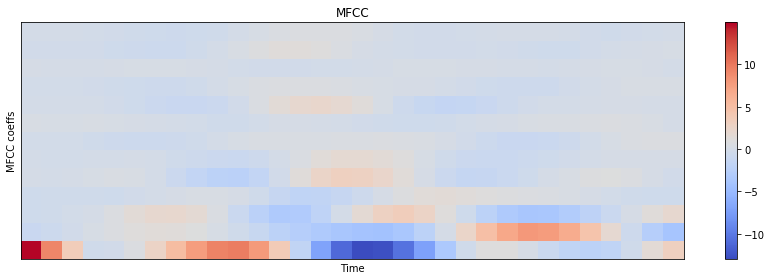

In [6]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# Feature Type 3: Filter Banks
http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [7]:
import numpy
from scipy.fftpack import dct

train_audio_path = 'train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, signal = wavfile.read(os.path.join(train_audio_path , filename))

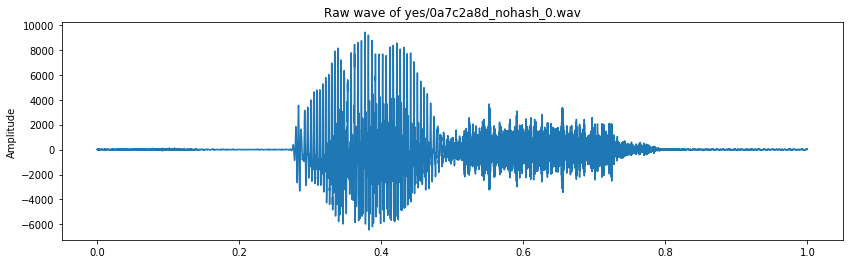

In [8]:
fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(111)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)

## Pre-Emphasis

to apply a pre-emphasis filter on the signal to amplify the high frequencies.

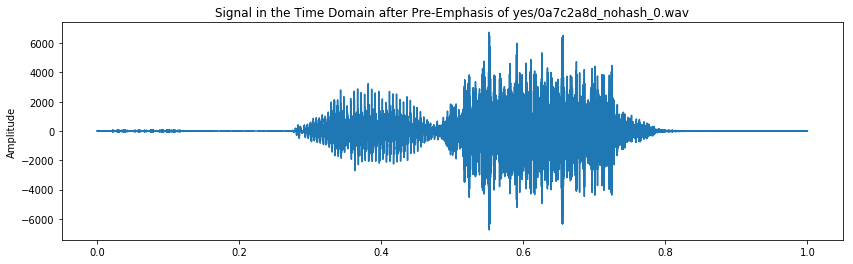

In [9]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(111)
ax1.set_title('Signal in the Time Domain after Pre-Emphasis of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(emphasized_signal), sample_rate), emphasized_signal)

## Framing

After pre-emphasis, we need to split the signal into short-time frames.

In [10]:
frame_size = 0.025 
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

## Window
After slicing the signal into frames, we apply a window function such as the Hamming window to each frame

In [11]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

# Fourier-Transform and Power Spectrum

In [12]:
NFFT = 512

mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

## Filter Banks

In [13]:
nfilt = 40

low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

Text(0.5,1,'Filter Bank')

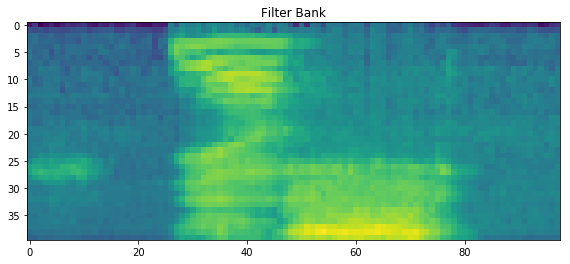

In [14]:
plt.figure(figsize=(12, 4))
plt.imshow(filter_banks.T)
plt.title('Filter Bank')

# Prepare Train set and Test set

In [15]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import librosa

def wav2mfcc(file_path, max_pad_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc


labelset = 'yes no up down left right on off stop go'.split()


def get_train_test(split_ratio=0.6, random_state=42, max_pad_len=11):
    # Get available labels
    i = 0
    X = []
    y = []
    for label in labelset:
        path = os.path.join('train/audio', label)
        
        for file in os.listdir(path):
            wavpath = os.path.join(path, file)
            
            mfcc = wav2mfcc(wavpath, max_pad_len)
            
            X.append(mfcc)
            y.append(i)
        print('loaded label {} = {} ( {} files)'.format(i, label, len(os.listdir(path))))
            
        i += 1
        
    
    X = np.array(X)
    print(X.shape)
    y = np.array(y)
    print(y.shape)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)


In [16]:
X_train, X_test, y_train, y_test = get_train_test(0.8)
X_train.shape

loaded label 0 = yes ( 2377 files)
loaded label 1 = no ( 2375 files)
loaded label 2 = up ( 2375 files)
loaded label 3 = down ( 2359 files)
loaded label 4 = left ( 2353 files)
loaded label 5 = right ( 2367 files)
loaded label 6 = on ( 2367 files)
loaded label 7 = off ( 2357 files)
loaded label 8 = stop ( 2380 files)
loaded label 9 = go ( 2372 files)
(23682, 20, 11)
(23682,)


(18945, 20, 11)

In [17]:
from keras.utils import to_categorical

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

Using TensorFlow backend.


# CNN Model --- MFCC features

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

X_train = X_train.reshape(X_train.shape[0], 20, 11, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 11, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(20, 11, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [19]:
model.fit(X_train, y_train_hot, batch_size=100, epochs=500, verbose=2, shuffle=True,validation_data=(X_test, y_test_hot))

Train on 18945 samples, validate on 4737 samples
Epoch 1/500
 - 6s - loss: 7.0827 - acc: 0.1251 - val_loss: 2.3024 - val_acc: 0.1039
Epoch 2/500
 - 1s - loss: 2.3202 - acc: 0.1178 - val_loss: 2.2861 - val_acc: 0.1146
Epoch 3/500
 - 1s - loss: 2.2466 - acc: 0.1607 - val_loss: 2.0957 - val_acc: 0.2324
Epoch 4/500
 - 1s - loss: 2.1408 - acc: 0.2052 - val_loss: 1.9780 - val_acc: 0.2592
Epoch 5/500
 - 1s - loss: 2.0562 - acc: 0.2257 - val_loss: 1.8676 - val_acc: 0.3091
Epoch 6/500
 - 1s - loss: 1.9775 - acc: 0.2622 - val_loss: 1.7870 - val_acc: 0.3479
Epoch 7/500
 - 1s - loss: 1.9246 - acc: 0.2897 - val_loss: 1.7435 - val_acc: 0.3741
Epoch 8/500
 - 1s - loss: 1.8724 - acc: 0.3025 - val_loss: 1.6737 - val_acc: 0.4176
Epoch 9/500
 - 1s - loss: 1.8171 - acc: 0.3310 - val_loss: 1.6038 - val_acc: 0.4463
Epoch 10/500
 - 1s - loss: 1.7738 - acc: 0.3433 - val_loss: 1.5555 - val_acc: 0.4687
Epoch 11/500
 - 1s - loss: 1.7281 - acc: 0.3658 - val_loss: 1.5249 - val_acc: 0.4896
Epoch 12/500
 - 1s - loss

Epoch 97/500
 - 1s - loss: 0.7390 - acc: 0.7370 - val_loss: 0.5850 - val_acc: 0.8035
Epoch 98/500
 - 1s - loss: 0.7252 - acc: 0.7432 - val_loss: 0.5902 - val_acc: 0.8041
Epoch 99/500
 - 1s - loss: 0.7289 - acc: 0.7456 - val_loss: 0.5863 - val_acc: 0.8049
Epoch 100/500
 - 1s - loss: 0.7350 - acc: 0.7429 - val_loss: 0.6025 - val_acc: 0.8014
Epoch 101/500
 - 1s - loss: 0.7215 - acc: 0.7487 - val_loss: 0.5855 - val_acc: 0.8052
Epoch 102/500
 - 1s - loss: 0.7198 - acc: 0.7445 - val_loss: 0.5844 - val_acc: 0.8056
Epoch 103/500
 - 1s - loss: 0.7121 - acc: 0.7493 - val_loss: 0.5847 - val_acc: 0.8037
Epoch 104/500
 - 1s - loss: 0.7160 - acc: 0.7484 - val_loss: 0.5884 - val_acc: 0.8047
Epoch 105/500
 - 1s - loss: 0.7103 - acc: 0.7524 - val_loss: 0.5810 - val_acc: 0.8096
Epoch 106/500
 - 1s - loss: 0.7114 - acc: 0.7499 - val_loss: 0.5847 - val_acc: 0.8037
Epoch 107/500
 - 1s - loss: 0.7039 - acc: 0.7540 - val_loss: 0.5709 - val_acc: 0.8060
Epoch 108/500
 - 1s - loss: 0.7043 - acc: 0.7504 - val_lo

Epoch 193/500
 - 1s - loss: 0.5372 - acc: 0.8092 - val_loss: 0.5373 - val_acc: 0.8214
Epoch 194/500
 - 1s - loss: 0.5286 - acc: 0.8138 - val_loss: 0.5318 - val_acc: 0.8191
Epoch 195/500
 - 1s - loss: 0.5318 - acc: 0.8138 - val_loss: 0.5382 - val_acc: 0.8214
Epoch 196/500
 - 1s - loss: 0.5242 - acc: 0.8148 - val_loss: 0.5447 - val_acc: 0.8174
Epoch 197/500
 - 1s - loss: 0.5195 - acc: 0.8177 - val_loss: 0.5306 - val_acc: 0.8246
Epoch 198/500
 - 1s - loss: 0.5309 - acc: 0.8142 - val_loss: 0.5280 - val_acc: 0.8244
Epoch 199/500
 - 1s - loss: 0.5331 - acc: 0.8120 - val_loss: 0.5280 - val_acc: 0.8248
Epoch 200/500
 - 1s - loss: 0.5211 - acc: 0.8143 - val_loss: 0.5246 - val_acc: 0.8273
Epoch 201/500
 - 1s - loss: 0.5177 - acc: 0.8157 - val_loss: 0.5325 - val_acc: 0.8220
Epoch 202/500
 - 1s - loss: 0.5250 - acc: 0.8156 - val_loss: 0.5376 - val_acc: 0.8220
Epoch 203/500
 - 1s - loss: 0.5205 - acc: 0.8182 - val_loss: 0.5310 - val_acc: 0.8214
Epoch 204/500
 - 1s - loss: 0.5197 - acc: 0.8183 - val

Epoch 289/500
 - 1s - loss: 0.4507 - acc: 0.8420 - val_loss: 0.5298 - val_acc: 0.8258
Epoch 290/500
 - 1s - loss: 0.4469 - acc: 0.8428 - val_loss: 0.5258 - val_acc: 0.8282
Epoch 291/500
 - 1s - loss: 0.4531 - acc: 0.8404 - val_loss: 0.5246 - val_acc: 0.8258
Epoch 292/500
 - 1s - loss: 0.4440 - acc: 0.8439 - val_loss: 0.5169 - val_acc: 0.8299
Epoch 293/500
 - 1s - loss: 0.4431 - acc: 0.8420 - val_loss: 0.5253 - val_acc: 0.8292
Epoch 294/500
 - 1s - loss: 0.4414 - acc: 0.8456 - val_loss: 0.5297 - val_acc: 0.8307
Epoch 295/500
 - 1s - loss: 0.4474 - acc: 0.8413 - val_loss: 0.5196 - val_acc: 0.8299
Epoch 296/500
 - 1s - loss: 0.4438 - acc: 0.8454 - val_loss: 0.5278 - val_acc: 0.8282
Epoch 297/500
 - 1s - loss: 0.4481 - acc: 0.8453 - val_loss: 0.5258 - val_acc: 0.8263
Epoch 298/500
 - 1s - loss: 0.4453 - acc: 0.8453 - val_loss: 0.5209 - val_acc: 0.8288
Epoch 299/500
 - 1s - loss: 0.4390 - acc: 0.8452 - val_loss: 0.5331 - val_acc: 0.8322
Epoch 300/500
 - 1s - loss: 0.4447 - acc: 0.8433 - val

Epoch 385/500
 - 1s - loss: 0.3991 - acc: 0.8599 - val_loss: 0.5296 - val_acc: 0.8256
Epoch 386/500
 - 1s - loss: 0.3976 - acc: 0.8606 - val_loss: 0.5370 - val_acc: 0.8273
Epoch 387/500
 - 1s - loss: 0.3997 - acc: 0.8609 - val_loss: 0.5341 - val_acc: 0.8294
Epoch 388/500
 - 1s - loss: 0.4044 - acc: 0.8584 - val_loss: 0.5253 - val_acc: 0.8332
Epoch 389/500
 - 1s - loss: 0.3924 - acc: 0.8594 - val_loss: 0.5255 - val_acc: 0.8290
Epoch 390/500
 - 1s - loss: 0.3893 - acc: 0.8660 - val_loss: 0.5304 - val_acc: 0.8318
Epoch 391/500
 - 1s - loss: 0.3953 - acc: 0.8628 - val_loss: 0.5296 - val_acc: 0.8330
Epoch 392/500
 - 1s - loss: 0.3876 - acc: 0.8665 - val_loss: 0.5197 - val_acc: 0.8320
Epoch 393/500
 - 1s - loss: 0.4031 - acc: 0.8599 - val_loss: 0.5479 - val_acc: 0.8263
Epoch 394/500
 - 1s - loss: 0.3918 - acc: 0.8630 - val_loss: 0.5254 - val_acc: 0.8326
Epoch 395/500
 - 1s - loss: 0.3963 - acc: 0.8605 - val_loss: 0.5346 - val_acc: 0.8265
Epoch 396/500
 - 1s - loss: 0.3857 - acc: 0.8630 - val

Epoch 481/500
 - 1s - loss: 0.3624 - acc: 0.8750 - val_loss: 0.5433 - val_acc: 0.8318
Epoch 482/500
 - 1s - loss: 0.3642 - acc: 0.8743 - val_loss: 0.5485 - val_acc: 0.8345
Epoch 483/500
 - 1s - loss: 0.3466 - acc: 0.8808 - val_loss: 0.5443 - val_acc: 0.8353
Epoch 484/500
 - 1s - loss: 0.3537 - acc: 0.8801 - val_loss: 0.5476 - val_acc: 0.8330
Epoch 485/500
 - 1s - loss: 0.3676 - acc: 0.8746 - val_loss: 0.5466 - val_acc: 0.8284
Epoch 486/500
 - 1s - loss: 0.3603 - acc: 0.8756 - val_loss: 0.5458 - val_acc: 0.8311
Epoch 487/500
 - 1s - loss: 0.3506 - acc: 0.8778 - val_loss: 0.5384 - val_acc: 0.8315
Epoch 488/500
 - 1s - loss: 0.3700 - acc: 0.8725 - val_loss: 0.5367 - val_acc: 0.8374
Epoch 489/500
 - 1s - loss: 0.3587 - acc: 0.8761 - val_loss: 0.5456 - val_acc: 0.8372
Epoch 490/500
 - 1s - loss: 0.3626 - acc: 0.8723 - val_loss: 0.5349 - val_acc: 0.8334
Epoch 491/500
 - 1s - loss: 0.3571 - acc: 0.8759 - val_loss: 0.5507 - val_acc: 0.8322
Epoch 492/500
 - 1s - loss: 0.3611 - acc: 0.8769 - val

# GRU Model -- filter banks features

In [20]:
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
L = 16000

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def get_train_test(split_ratio=0.6, random_state=42, max_pad_len=11):
    # Get available labels
    i = 0
    X = np.zeros((23682, 99, 26),np.float32)

    y = []
    ix = 0

    for label in labelset:
        path = os.path.join('train/audio', label)
        
        for file in os.listdir(path):
            wavpath = os.path.join(path, file)
            sample_rate, samples = wavfile.read(wavpath)
            samples = pad_audio(samples)
            
            filter_banks = logfbank(samples)
            filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
            
            X[ix, :,:] = filter_banks
            y.append(i)
            ix += 1
        print('loaded label {} = {} ( {} files)'.format(i, label, len(os.listdir(path))))
            
        i += 1
        
    
   
    print(X.shape)
    y = np.vstack(y)
    print(y.shape)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)


X_train, X_test, y_train, y_test = get_train_test(0.8)
print(X_train.shape)

loaded label 0 = yes ( 2377 files)
loaded label 1 = no ( 2375 files)
loaded label 2 = up ( 2375 files)
loaded label 3 = down ( 2359 files)
loaded label 4 = left ( 2353 files)
loaded label 5 = right ( 2367 files)
loaded label 6 = on ( 2367 files)
loaded label 7 = off ( 2357 files)
loaded label 8 = stop ( 2380 files)
loaded label 9 = go ( 2372 files)
(23682, 99, 26)
(23682, 1)
(18945, 99, 26)


In [21]:
from keras.layers import GRU, Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, Conv3D, ConvLSTM2D


model = Sequential()
model.add(GRU(256,input_shape=(99,26)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['categorical_accuracy'])

In [22]:
model.fit(X_train, y_train_hot, batch_size=100, epochs=100, verbose=2,shuffle=True, validation_data=(X_test, y_test_hot))

Train on 18945 samples, validate on 4737 samples
Epoch 1/100
 - 32s - loss: 1.5407 - categorical_accuracy: 0.4594 - val_loss: 0.8748 - val_categorical_accuracy: 0.7040
Epoch 2/100
 - 32s - loss: 0.6938 - categorical_accuracy: 0.7799 - val_loss: 0.5470 - val_categorical_accuracy: 0.8244
Epoch 3/100
 - 33s - loss: 0.4757 - categorical_accuracy: 0.8501 - val_loss: 0.4044 - val_categorical_accuracy: 0.8693
Epoch 4/100
 - 32s - loss: 0.4301 - categorical_accuracy: 0.8683 - val_loss: 0.4824 - val_categorical_accuracy: 0.8531
Epoch 5/100
 - 32s - loss: 0.3445 - categorical_accuracy: 0.8922 - val_loss: 0.3645 - val_categorical_accuracy: 0.8816
Epoch 6/100
 - 32s - loss: 0.3278 - categorical_accuracy: 0.8966 - val_loss: 0.3625 - val_categorical_accuracy: 0.8845
Epoch 7/100
 - 32s - loss: 0.2660 - categorical_accuracy: 0.9146 - val_loss: 0.3306 - val_categorical_accuracy: 0.8923
Epoch 8/100
 - 32s - loss: 0.2534 - categorical_accuracy: 0.9216 - val_loss: 0.2700 - val_categorical_accuracy: 0.9134

Epoch 69/100
 - 30s - loss: 0.0944 - categorical_accuracy: 0.9713 - val_loss: 0.2631 - val_categorical_accuracy: 0.9301
Epoch 70/100
 - 30s - loss: 0.1072 - categorical_accuracy: 0.9665 - val_loss: 0.3267 - val_categorical_accuracy: 0.9177
Epoch 71/100
 - 30s - loss: 0.0975 - categorical_accuracy: 0.9694 - val_loss: 0.3308 - val_categorical_accuracy: 0.9177
Epoch 72/100
 - 31s - loss: 0.0739 - categorical_accuracy: 0.9772 - val_loss: 0.2483 - val_categorical_accuracy: 0.9365
Epoch 73/100
 - 31s - loss: 0.0661 - categorical_accuracy: 0.9795 - val_loss: 0.3020 - val_categorical_accuracy: 0.9246
Epoch 74/100
 - 31s - loss: 0.0876 - categorical_accuracy: 0.9733 - val_loss: 0.2984 - val_categorical_accuracy: 0.9217
Epoch 75/100
 - 31s - loss: 0.0732 - categorical_accuracy: 0.9757 - val_loss: 0.2807 - val_categorical_accuracy: 0.9337
Epoch 76/100
 - 31s - loss: 0.0667 - categorical_accuracy: 0.9785 - val_loss: 0.3090 - val_categorical_accuracy: 0.9251
Epoch 77/100
 - 31s - loss: 0.0656 - cat